In [1]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt

Current data is shaped: (1250, 100, 514)


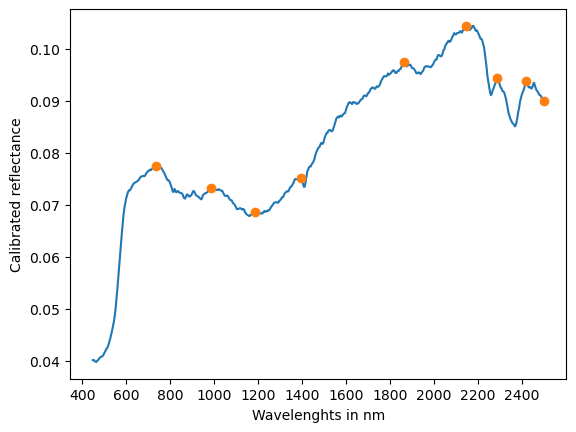

In [252]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 200
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

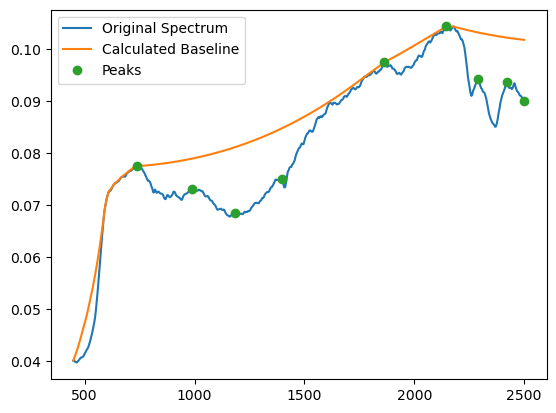

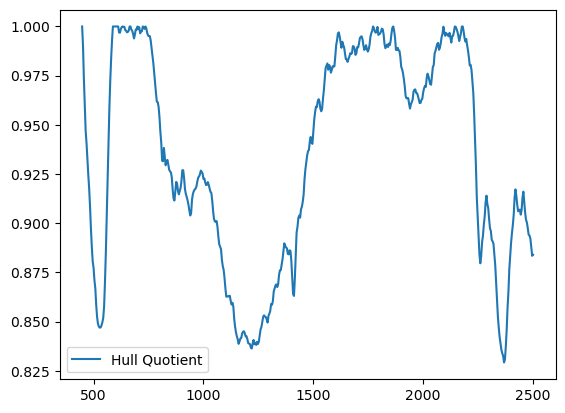

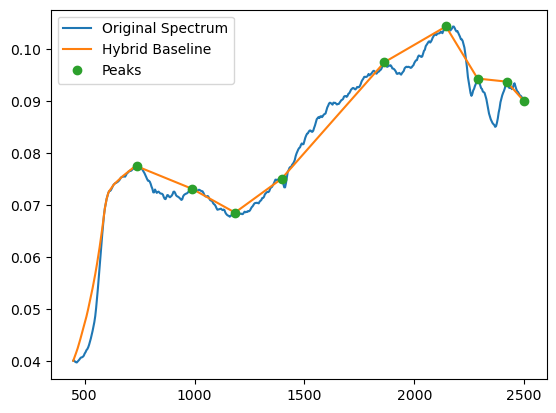

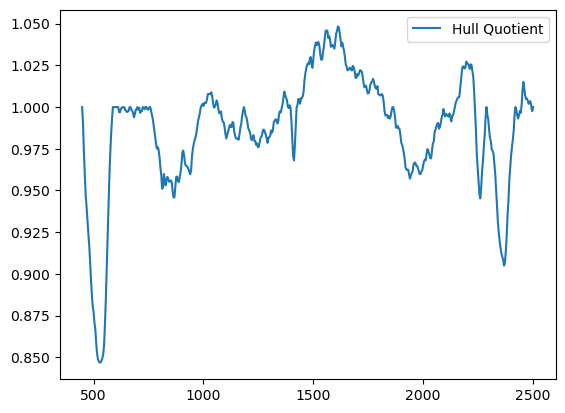

In [254]:
baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Invert the data 
pix_inverse = 1 / curr_pixel 

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/curr_baseline, label='Hull Quotient')
plt.legend()

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                              prelim_hull))
plt.figure()
plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

curr_quotient = curr_pixel/concat_hull

plt.figure()
plt.plot(wav_array,
         curr_quotient,
         label='Hull Quotient')
plt.legend()

In [5]:
# Master peak ranges
# This data will need to be committed to a database table so that it can be extracted
# in a more easily edited central location
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']
hull_correct_bool = [False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

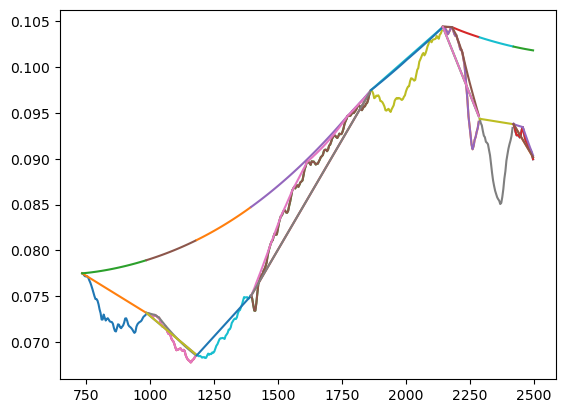

In [153]:

# Identify if the quotient contains any areas greater than 1 (it shouldn't)
n_gt_one = (curr_quotient > 1).sum()
# if n_gt_one > 0:
# # Replace hybrid locations with the original baseline if it crossed zero
#     concat_hull[curr_quotient > 1] = curr_baseline[curr_quotient > 1]
#     plt.figure()
#     plt.plot(wav_array, curr_pixel, label='Original Spectrum')
#     plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
#     plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
#     plt.legend()

# Try something iterative here
# Start by only altering segments

reconfigured_hull = np.empty(0)
patched_together_x = np.empty(0)

for i in range(len(peaks)-1):
    # i = 1
    curr_start = peaks[i]
    curr_end = peaks[i+1]
    curr_segment = curr_pixel[curr_start:curr_end]
    curr_xsegment = wav_array[curr_start:curr_end]
    curr_hull_seg = concat_hull[curr_start:curr_end]
    curr_base_seg = curr_baseline[curr_start:curr_end]
    
    plt.plot(curr_xsegment, curr_segment, label = 'Original spectrum')
    plt.plot(curr_xsegment, curr_hull_seg, label = 'Fitted hull')
    plt.plot(curr_xsegment, curr_base_seg, label = 'Convex hull')
    # plt.legend()
    
    if (curr_hull_seg < curr_segment).sum() > 10:
        
        # Refit a new baseline
        baseline_fitter = Baseline(curr_xsegment,
                                   check_finite=False)
        
        # # Invert the data 
        seg_inverse = 1 / curr_segment 
        
        # Calculate the baseline
        baseline_seg = baseline_fitter.snip(seg_inverse,
                                     max_half_window=12,
                                     decreasing=True,
                                     smooth_half_window=0)[0]
        
        # Invert the result
        inv_baselin_seg = 1 / baseline_seg         
        
        plt.plot(curr_xsegment, curr_segment, label='Original Spectrum')
        plt.plot(curr_xsegment, inv_baselin_seg, label='Calculated Baseline')
        plt.plot(curr_xsegment, curr_hull_seg)
        # plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
        # plt.legend()
        
        # Save the current segment
        reconfigured_hull = np.concatenate((reconfigured_hull, inv_baselin_seg))
        patched_together_x = np.concatenate((patched_together_x, curr_xsegment))
    else:
        # Save the original segment if nothing is wrong with it
        reconfigured_hull = np.concatenate((reconfigured_hull, curr_segment))
        patched_together_x = np.concatenate((patched_together_x, curr_xsegment))


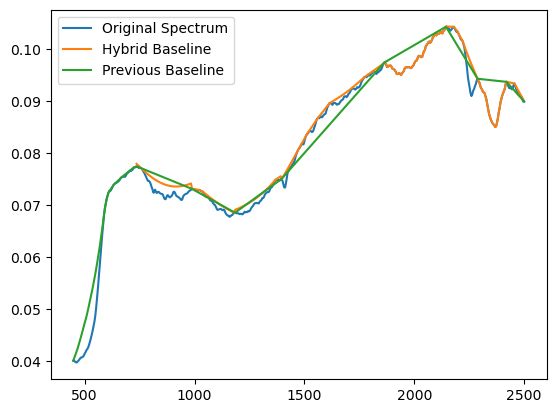

In [150]:
plt.figure()
plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(patched_together_x, reconfigured_hull, label='Hybrid Baseline')
plt.plot(wav_array, concat_hull, label='Previous Baseline')
plt.legend()

Signature:
find_peaks(
    x,
    height=None,
    threshold=None,
    distance=None,
    prominence=None,
    width=None,
    wlen=None,
    rel_height=0.5,
    plateau_size=None,
)
Docstring:
Find peaks inside a signal based on peak properties.

This function takes a 1-D array and finds all local maxima by
simple comparison of neighboring values. Optionally, a subset of these
peaks can be selected by specifying conditions for a peak's properties.

Parameters
----------
x : sequence
    A signal with peaks.
height : number or ndarray or sequence, optional
    Required height of peaks. Either a number, ``None``, an array matching
    `x` or a 2-element sequence of the former. The first element is
    always interpreted as the  minimal and the second, if supplied, as the
    maximal required height.
threshold : number or ndarray or sequence, optional
    Required threshold of peaks, the vertical distance to its neighboring
    samples. Either a number, ``None``, an array matching `x` or

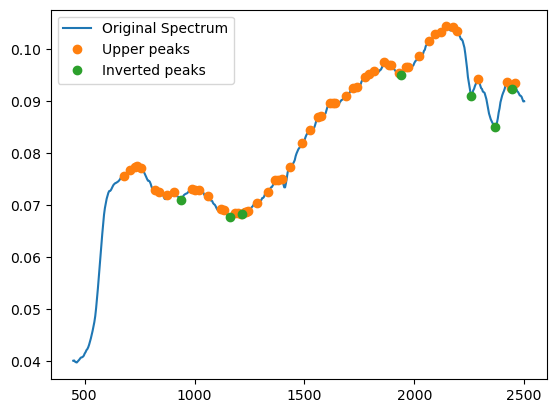

In [185]:
plt.plot(wav_array, curr_pixel, label = 'Original Spectrum')
up_peaks = find_peaks(curr_pixel,
                   height = .05)[0]
down_peaks = find_peaks(1/curr_pixel,
                   width = 5)[0]
plt.plot(wav_array[up_peaks], curr_pixel[up_peaks], 'o', label = 'Upper peaks')
plt.plot(wav_array[down_peaks], curr_pixel[down_peaks], 'o', label = 'Inverted peaks')

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


# prelim_upper_hull = interpolate_linear(curr_pixel[up_peaks[0]:],
#                                  up_peaks - up_peaks[0])

# concat_upper_hull = np.concatenate((curr_baseline[0:up_peaks[0]],
#                               prelim_upper_hull))
# plt.plot(wav_array, concat_upper_hull, label = 'Upper Hull')

plt.legend()

# find_peaks?
    # height=None,
    # threshold=None,
    # distance=None,
    # prominence=None,
    # width=None,
    # wlen=None,
    # rel_height=0.5,
    # plateau_size=None,
find_peaks?

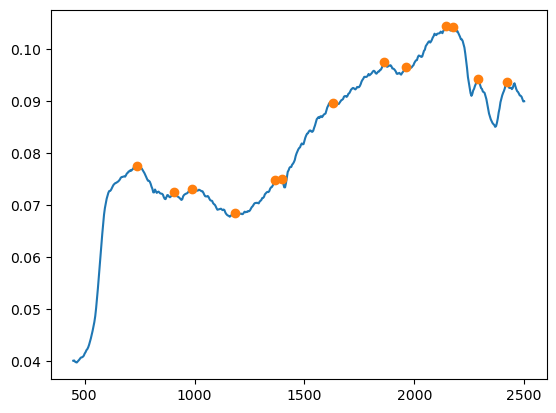

True


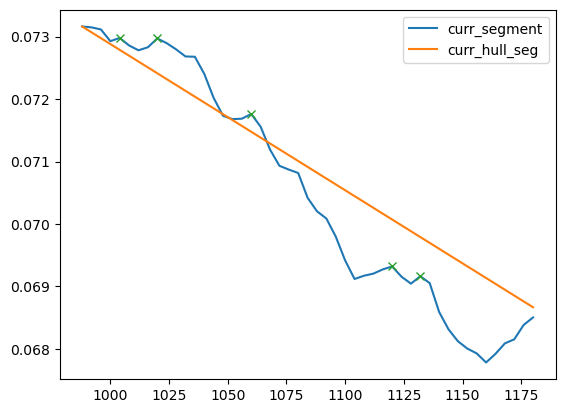

In [273]:
# Identify if the quotient contains any areas greater than 1 (it shouldn't)
n_gt_one = (curr_quotient > 1).sum()
# if n_gt_one > 0:
# # Replace hybrid locations with the original baseline if it crossed zero
#     concat_hull[curr_quotient > 1] = curr_baseline[curr_quotient > 1]
#     plt.figure()
#     plt.plot(wav_array, curr_pixel, label='Original Spectrum')
#     plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
#     plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
#     plt.legend()

# plt.plot(wav_array, curr_pixel)
# plt.plot(wav_array, concat_hull)
# plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

# Iterate the segments so far:

# for i in range(len(peaks)-1):
i = 1

curr_start = peaks[i]
curr_end = peaks[i+1]
curr_segment = curr_pixel[curr_start:curr_end]
curr_xsegment = wav_array[curr_start:curr_end]
curr_hull_seg = concat_hull[curr_start:curr_end]
curr_base_seg = curr_baseline[curr_start:curr_end]

plt.figure()
plt.plot(curr_xsegment, curr_segment, label = 'curr_segment')
plt.plot(curr_xsegment, curr_hull_seg, label = 'curr_hull_seg')
# plt.plot(curr_xsegment, curr_base_seg, label = 'curr_base_seg')
plt.legend()

print((curr_hull_seg < curr_segment).sum() > 2)
int_peaks = find_peaks(curr_segment )[0]
plt.plot(curr_xsegment[int_peaks],
         curr_segment[int_peaks],
         'x',
         label = 'curr_segment peaks')

# Interpolate linearly to get the hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull

valid_peaks = int_peaks[curr_hull_seg[int_peaks] <= curr_segment[int_peaks]]

# test_hull = interpolate_linear(curr_segment[valid_peaks[0]:],
#                                  valid_peaks - valid_peaks[0])

# # concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
# #                               prelim_hull))
# plt.figure()
# plt.plot(curr_xsegment, curr_segment)
# plt.plot(curr_xsegment[valid_peaks], curr_segment[valid_peaks], 'o')

# plt.figure()
# plt.plot(test_hull)
